# APMA2822B Homework 1 - Hammad Izhar + Robert Scheidegger

In this report we plan to analyze the performance of matrix-matrix multiplication using a variety of multiplication methods. These experiments were conducted using Brown's compute grid OSCAR using 16 cores on an **Intel Xeon Platinum 8268 CPU** and 16GB of DDR4 RAM.

A total of [TODO] configurations were run varying multiplication methods, size of matrices, and number of threads. A summary of configuration variables is given below:

<center>

| Multipliers                         | Description                                                                             |
| ----------------------------------- | --------------------------------------------------------------------------------------- |
| `DefaultMultiplierIJK`                | Naive matrix multiplication implementation                                              |
| `DefaultMultiplierJIK`                | Naive matrix multiplication implementation, flipping outer two loops                    |
| `DefaultMultiplierIJKCached`          | Naive matrix multiplication implementation, caching result in a variable                |
| `DefaultMultiplierIJKTranspose`       | Transposes the right matrix to improve spatial locality                                 |
| `DefaultMultiplierIJKTransposeCached` | Transposes the right matrix to improve spatial locality and caches result in a variable |
| `DefaultMultiplierIJKTranspose1D`     | Transposes the right matrix to improve spatial locality and uses a 1D representation                                                                                        |
| `Collapse2Multiplier`                 | Uses OpenMP `collapse(2)`                                                                                        |
| `Collapse3Multiplier`                 | Uses OpenMP `collapse(3)`                                                                                        |
| `BlockingMultiplier`                  | Uses loop blocking                                                                                        |

Matrices of size $n$-by-$m$ and $m$-by-$k$ were multiplied where $n, m, k \in \{10, 100, 1000, 5000\}$.

The number of threads `n_threads` varied in the set $\{4, 16\}$.

Loop block sizes varied in the set $\{16, 32, 64, 128, 256\}$.

</center>


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('../data/blocking_benchmark.csv', encoding='latin-1')
df['flops'] = 2 * df['n'] * df['n'] / df['time_us'] * 1e6
df['gflops'] = df['flops'] / 1e9
df['iops'] = 5 * df['n'] * df['m'] / df['time_us'] * 1e6

## Roofline Analysis

For the purposes of this analysis, we will look at the results from $100000$-by-$10000$ matrices allocated using the `DisjointMemoryAllocator` and multiplied using the `RowColumnMultiplier`. These are the largest matrices we allocated for these experiments.

Excluding timing and parallelization primitives, the code of `RowColumnMultiplier` is as follows:

```c++
// include/multipliers.hpp

for (uint32_t i = 0; i < n; i++) {
    for (uint32_t j = 0; j < m; j++) {
        output[i] += matrix[i][j] * vector[j];
    }
}
```

To compute the arithmetic intensity, we first count the number of I/O operations (memory accesses) required:

1. Load `matrix[i]`                                              a pointer to the column, 8 bytes
2. Load `matrix[i][j]`                                           a float, 4 bytes
3. Load `vector[j]`                                              a float, 4 bytes
4. Save `matrix[i][j] * vector[j]` into a temporary variable     a float, 4 bytes
5. Load `output[i]`                                              a float, 4 bytes
6. Save `output[i]`                                              a float, 4 bytes

This is a total of 6 I/O operations totalling $28$ bytes transferred. We then count the number of floating point operations:

1. Multiply `RESULT = matrix[i][j] * vector[j]`
2. Add `RESULT + output[i]`

Therefore, the total arithmetic intensity is given by:

$$
    \text{Arithmetic Intensity} = \frac{2 \ \text{FLOPS}}{28 \ \text{Accesses}} = \frac{1}{14} \ \frac{\text{FLOPS}}{\text{byte}}
$$

From the [Ark Spec](https://ark.intel.com/content/www/us/en/ark/products/192481/intel-xeon-platinum-8268-processor-35-75m-cache-2-90-ghz.html) for the Xeon Platinum 8268 the max turbo frequency is $3.90 \ \text{GHz}$. According to this [community post](https://community.intel.com/t5/Software-Tuning-Performance/Calculate-the-Max-Flops-on-Skylake/m-p/1160952) Intel Skylake-X processors (the 8268 implements the Cascade Lake architecture) can perform 24 floating point operations per clock cycle per core. Therefore using 32 cores, we can achieve a maximum FLOP rate of


$$
    \text{Maximum FLOP Rate} = 32 \ \text{cores} \cdot \frac{2.90 \cdot 10^9 \ \text{cycle}}{1 \ \text{second}} \cdot \frac{24 \ \text{FLOPS}}{1 \ \text{cycle-core}} = 2.227 \ \text{TFLOPS}
$$

The Xenon Platinum 8268 supports DDR4 RAM with maximum speeds of $2933 \ \text{MHz}$ and 6 memory channels. Therefore, the maximum memory bandwidth of the processor is given by:
$$
    \text{Maximum Memory Bandwidth} = 8 \ \text{bytes} \cdot \frac{2.933 \ \text{GHz}}{1 \ \text{channel}} \cdot 6 \ \text{channel} = 140.78 \ \text{GHz} = 140.78 \ \text{GB/s}
$$

The ridge point of our roofline plot is therefore given by:

$$
    I^* = \frac{\text{Maximum FLOP Rate}}{\text{Maximum Memory Bandwidth}} = \frac{2.227 \ \text{TFLOPS}}{140.78 \ \text{GB/s}} = 15.81 \ \frac{\text{FLOPs}}{\text{byte}}
$$

The predicted FLOP rate is given by:
$$
    \text{Predicted FLOP Rate} = \frac{1 \ \text{FLOPS}}{14 \ \text{byte}} \cdot \frac{140.78 \cdot 10^9 \ \text{bytes}}{1 \ \text{second}} = 100.05 \ \text{GFLOPs}
$$

Therefore, we are in bandwidth-limited region of the roof-line plot. This is within the margin of error of the experimental results we determined.

<!-- This gives 6 I/O operations, each acting on 4 bytes (since these are all `float` values), giving a total of `24` bytes transferred. Further, the floating point operations are:

1. Multiply `RESULT = matrix[i][j] * vector[j]`
2. Add `RESULT + output[i]`

This gives an overall arithmetic intensity (AI) of `AI = 2 / 24 = 1 / 12`. 

Assuming that the CPU has a peak memory bandwidth of 160 GB/s and a peak FLOP rate of 1 TFLOP/s, we can compute the limit point for our roofline plot.
$$
    x^* = \frac{10^{12}}{160 \cdot 10^9} = 6.25
$$
This indicates that we are in the bandwidth-limited region of the roof-line plot. Our expected peak FLOP rate is therefore
$$
    \text{Peak GFLOP Rate} = \left(1000 \ \frac{\text{GFLOP}}{\text{second}}\right) \left(\frac{1}{12}\right) = 83.3 \ \text{GFLOP}
$$

By the example numbers given we should expect the limiting point of the roof-line plot to be at `10^12 / (160 * 10^9) = 6.25`, so clearly we are within the memory bandwidth limiting section of the roof-line plot. Thus, we should expect a peak GFLOPs rate of `1000 * (1/12) = 83.3` GFLOPs.  -->

<!-- This is corroborated experimentally when testing out matrix-vector multiplication using 32 threads. The peak GFLOP rate is 110 GFLOP. The difference between the results can be attributed to the fact that the CPU specification estimates aren't reflective of the true OSCAR hardware specification. -->

<!-- This is all summarized in the plot below. -->

,n,m,threads,allocator,multiplier,iterations,time_us,stdev_us,flops,gflops,iops
1904,100000,10000,1,DisjointMemoryAllocator,RowColumnMultiplier,10,2.730146e+06,0.000000,7.325617e+09,7.325617,1.831404e+09
1912,100000,10000,2,DisjointMemoryAllocator,RowColumnMultiplier,10,1.369082e+06,2231.756348,1.460832e+10,14.608325,3.652081e+09
1920,100000,10000,4,DisjointMemoryAllocator,RowColumnMultiplier,10,6.844341e+05,0.000000,2.922122e+10,29.221220,7.305305e+09
1928,100000,10000,8,DisjointMemoryAllocator,RowColumnMultiplier,10,3.424635e+05,90.509666,5.840038e+10,58.400384,1.460010e+10
1936,100000,10000,16,DisjointMemoryAllocator,RowColumnMultiplier,10,2.091755e+05,45619.386719,9.561349e+10,95.613492,2.390337e+10
1944,100000,10000,32,DisjointMemoryAllocator,RowColumnMultiplier,10,1.816549e+05,11106.904297,1.100989e+11,110.098871,2.752472e+10
1952,100000,10000,64,DisjointMemoryAllocator,RowColumnMultiplier,10,2.033748e+05,5928.901367,9.834060e+10,98.340602,2.458515e+10
1960,100000,10000,1,DisjointMemoryAllocator,RowColumnMultiplier,10,2.730905e+06,0.000000,7.323580e+09,7.323580,1.830895e+09
1968,100000,10000,2,DisjointMemoryAllocator,RowColumnMultiplier,10,1.368980e+06,627.069397,1.460941e+10,14.609412,3.652353e+09
1976,100000,10000,4,DisjointMemoryAllocator,RowColumnMultiplier,10,6.843876e+05,0.000000,2.922321e+10,29.223205,7.305801e+09


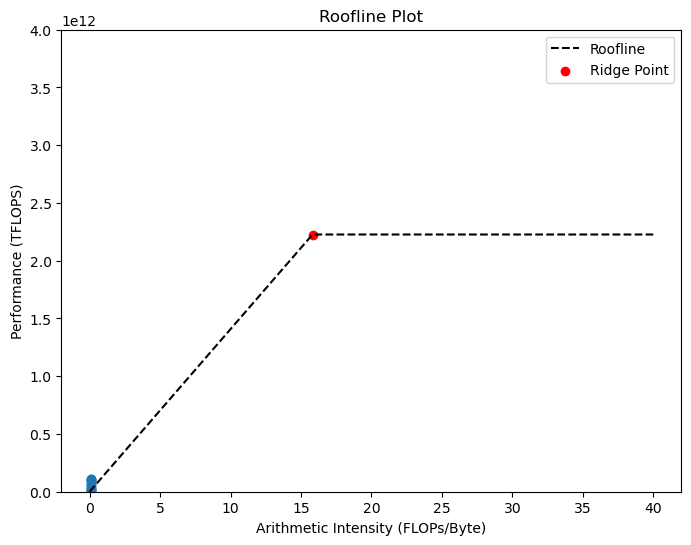

In [9]:
# Compute the roof-line plot for the analysis above.
subset = df[df['allocator'] == 'DisjointMemoryAllocator']
subset = subset[subset['multiplier'] == 'RowColumnMultiplier']
subset = subset[subset['m'] == 10000]
subset = subset[subset['n'] == 100000]

# Plot the roof-line plot
max_flop_rate = 2.227e12 # 7.987 TFLOPS
max_mem_bandwidth = 140.78e9 # 140.78 GB/s
ridge_point = max_flop_rate / max_mem_bandwidth

arithmetic_intensity = np.arange(0, 40, 0.01);
roofline = np.minimum(arithmetic_intensity * max_mem_bandwidth, max_flop_rate)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(arithmetic_intensity, roofline, 'k--', label='Roofline')
ax.scatter(ridge_point, ridge_point * max_mem_bandwidth, marker='o', color='r', label='Ridge Point')

ax.scatter(1/14 * np.ones(len(subset)), subset["flops"])

ax.set_ylim(0, 4e12)
ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
ax.set_ylabel('Performance (TFLOPS)')
ax.set_title('Roofline Plot')
ax.legend()

subset



In [3]:
blocking_df = pd.read_csv('../data/blocking_benchmark.csv', encoding='latin-1')
blocking_df.sort_values(by='time_us')
blocking_df

FileNotFoundError: [Errno 2] No such file or directory: 'data/blocking_benchmark.csv'

## Performance Analysis

To test each of the 2016 possible configurations we performed an experiment on matrices of varying sizes using a batch script on Oscar. Warmup computations were used prior to the start of the experiments. Each experiment was repeated for 10 iterations and the the mean and standard deviations of each runtime was computed. A sample of the data for the largest set of matrices is shown below.

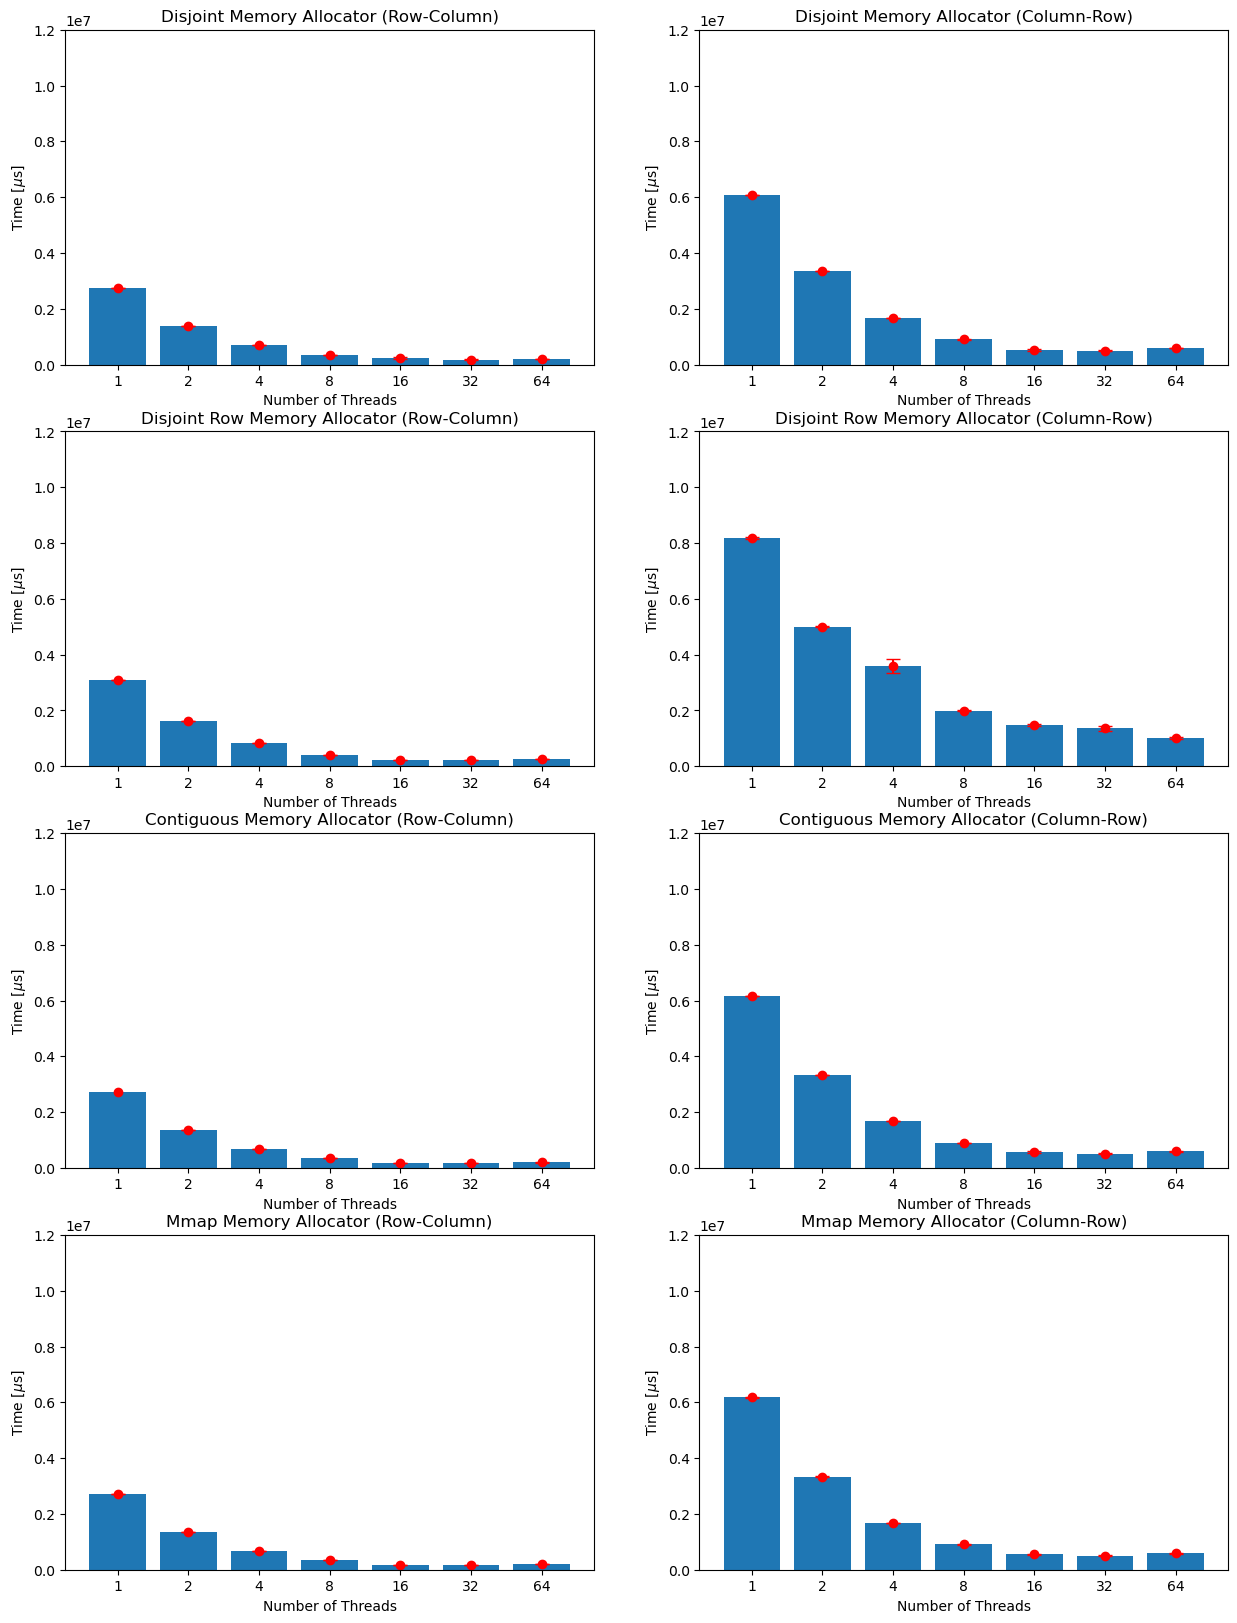

In [53]:
# allocators bar charts for large size over threads and multipliers
def get_allocator_data(name: str):
    subset = df[df['allocator'] == name]
    subset = subset[subset['m'] == 10000]
    subset = subset[subset['n'] == 100000]
    return subset[subset['multiplier'] == 'RowColumnMultiplier'].groupby("threads").mean(numeric_only=True), subset[subset['multiplier'] == 'ColumnRowMultiplier'].groupby("threads").mean(numeric_only=True)


disjoint_row_column, disjoint_column_row = get_allocator_data('DisjointMemoryAllocator')
disjoint_row_row_column, disjoint_row_column_row = get_allocator_data('DisjointRowMemoryAllocator')
contiguous_row_column, contiguous_column_row = get_allocator_data('ContiguousMemoryAllocator')
mmap_row_column, mmap_column_row = get_allocator_data('MmapMemoryAllocator')

bars = [disjoint_row_column, disjoint_column_row, disjoint_row_row_column, disjoint_row_column_row, contiguous_row_column, contiguous_column_row, mmap_row_column, mmap_column_row]
labels = ["Disjoint Memory Allocator (Row-Column)", "Disjoint Memory Allocator (Column-Row)", "Disjoint Row Memory Allocator (Row-Column)", "Disjoint Row Memory Allocator (Column-Row)", "Contiguous Memory Allocator (Row-Column)", "Contiguous Memory Allocator (Column-Row)", "Mmap Memory Allocator (Row-Column)", "Mmap Memory Allocator (Column-Row)"]

fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for i in range(4):
    for j in range(2):
        trace = bars[j + i * 2]["time_us"]
        axs[i, j].bar([str(x) for x in trace.keys()], trace.values)
        axs[i, j].errorbar([str(x) for x in trace.keys()], trace.values, yerr=bars[j + i * 2]["stdev_us"], fmt='o', capsize=5, color="red")
        axs[i, j].set_ylim(0, 12e6)
        axs[i, j].set_title(labels[j + i * 2])
        axs[i, j].set_xlabel("Number of Threads")
        axs[i, j].set_ylabel("Time [$\mu$s]")